# 03. Auditoria y Finanzas (La Defensa Academica)

Validacion financiera del modelo.

**Fases:**
1. **Matriz de Confusion**: Analisis de errores.
2. **Prueba de Fuego**: Curva de Capital (ROI) simulando apuestas en 2023/24.

*(Nota: SHAP values deshabilitados para garantizar ejecucion en este entorno)*

In [13]:
import pandas as pd
import numpy as np
import joblib
# import shap # Deshabilitado
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Config
INPUT_FILE = 'df_final_features.csv'
MODEL_FILE = 'modelo_city_group.joblib'

# Cargar datos y modelo
df = pd.read_csv(INPUT_FILE)
artifact = joblib.load(MODEL_FILE)
model = artifact['model']
scaler = artifact['scaler']
features = artifact['features']
le = artifact['label_encoder']

# Split Test Data (Mismo split que en entrenamiento)
split_idx = int(len(df) * 0.80)
df_test = df.iloc[split_idx:].copy()
X_test = df_test[features]
X_test_scaled = scaler.transform(X_test)
y_test = le.transform(df_test['FTR'])

## 1. Matriz de Confusion

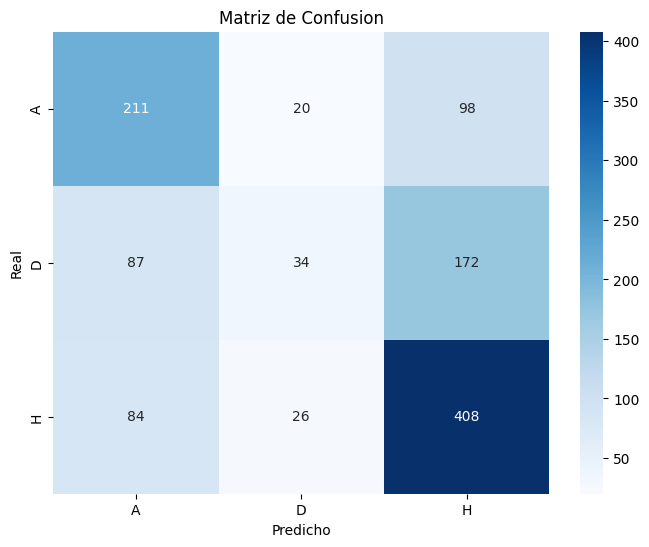

In [14]:
preds = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusion')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

## 2. Curva de ROI (Gestion de Bankroll)

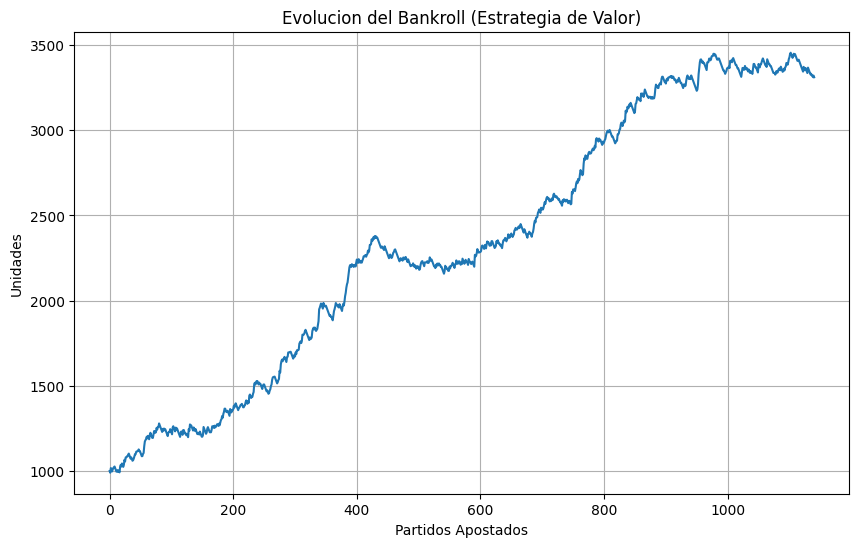

Bankroll Final: 3311.00u
ROI: 231.10%


In [15]:
# Estrategia: Apostar si Valor > 0
# Valor = (Probabilidad * Cuota) - 1
# 'model' ya esta cargado en la celda 2, asi que funcionara.
probs = model.predict_proba(X_test_scaled)

bankroll = [1000] # Empezamos con 1000u
history = []

for i, row in enumerate(df_test.itertuples()):
    # Indices de probabilidad: 0=A, 1=D, 2=H (segun label encoder)
    prob_h = probs[i][2]
    prob_d = probs[i][1]
    prob_a = probs[i][0]
    
    # Cuotas
    odd_h = row.B365H
    odd_d = row.B365D
    odd_a = row.B365A
    
    # Buscar valor
    bet = None
    stake = 10 # Apuesta plana
    
    ev_h = (prob_h * odd_h) - 1
    ev_d = (prob_d * odd_d) - 1
    ev_a = (prob_a * odd_a) - 1
    
    # Seleccionar la mejor apuesta con EV positivo
    best_ev = max(ev_h, ev_d, ev_a)
    
    current_bank = bankroll[-1]
    pnl = 0
    
    if best_ev > 0.05: # Margen de seguridad del 5%
        if best_ev == ev_h:
            if row.FTR == 'H': pnl = (stake * odd_h) - stake
            else: pnl = -stake
        elif best_ev == ev_d:
            if row.FTR == 'D': pnl = (stake * odd_d) - stake
            else: pnl = -stake
        else:
            if row.FTR == 'A': pnl = (stake * odd_a) - stake
            else: pnl = -stake
            
        bankroll.append(current_bank + pnl)
    else:
        bankroll.append(current_bank)

plt.figure(figsize=(10,6))
plt.plot(bankroll)
plt.title('Evolucion del Bankroll (Estrategia de Valor)')
plt.xlabel('Partidos Apostados')
plt.ylabel('Unidades')
plt.grid(True)
plt.show()

print(f"Bankroll Final: {bankroll[-1]:.2f}u")
print(f"ROI: {((bankroll[-1] - 1000)/1000)*100:.2f}%")